In [1]:
# ! pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow_hub as hub

# load data

In [3]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-08-28 17:36:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   164MB/s    in 1.0s    

2025-08-28 17:36:32 (164 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#  How many images in each folder?
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

# preprocessing the data


In [5]:
# normalized the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

IMAGE_SHAPE = (224, 224)
# training image

train_data=train_datagen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=32,
                                              class_mode="categorical")

# testing image

test_data =test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=32,
                                              class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Setting up callbacks (things to run whilst our model trains)

In [6]:
# create tensorboard
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# def create_model(model_url, num_classes=10):
#   """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

#   Args:
#     model_url (str): A TensorFlow Hub feature extraction URL.
#     num_classes (int): Number of output neurons in output layer,
#       should be equal to number of target classes, default 10.

#   Returns:
#     An uncompiled Keras Sequential model with model_url as feature
#     extractor layer and Dense output layer with num_classes outputs.
#   """
#   # Download the pretrained model and save it as a Keras layer
#   feature_extractor_layer = hub.KerasLayer(model_url,
#                                            trainable=False, # freeze the underlying patterns
#                                            name='feature_extraction_layer',
#                                            input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

#   # Create our own model
#   model = tf.keras.Sequential([
#     feature_extractor_layer, # use the feature extraction layer as the base
#     layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
#   ])

#   return model


In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url, num_classes=10):
    """Using Lambda layer to wrap the Hub layer"""
    # Input layer
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Wrap Hub layer in Lambda layer and import pretrain model
    hub_layer = hub.KerasLayer(
        model_url,
        trainable=False
    )

    x = layers.Lambda(lambda x: hub_layer(x), name='feature_extraction_layer')(inputs)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
resnet_model=create_model(resnet_url,num_classes=train_data.num_classes)

In [12]:
# train_data.classes

In [13]:
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [14]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250828-173638


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 469s 20s/step - accuracy: 0.2390 - loss: 2.2704 - val_accuracy: 0.6132 - val_loss: 1.2327
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 530s 21s/step - accuracy: 0.6773 - loss: 1.0415 - val_accuracy: 0.7100 - val_loss: 0.8837
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 475s 20s/step - accuracy: 0.8198 - loss: 0.6210 - val_accuracy: 0.7512 - val_loss: 0.7637
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 491s 21s/step - accuracy: 0.8565 - loss: 0.5037 - val_accuracy: 0.7624 - val_loss: 0.7263
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 462s 19s/step - accuracy: 0.8918 - loss: 0.4205 - val_accuracy: 0.7740 - val_loss: 0.6865


# visulazation


In [15]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


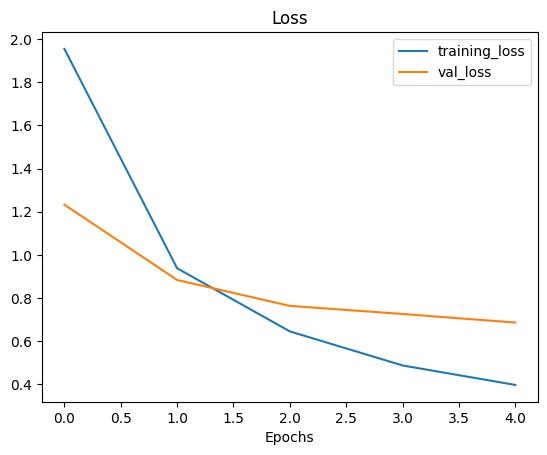

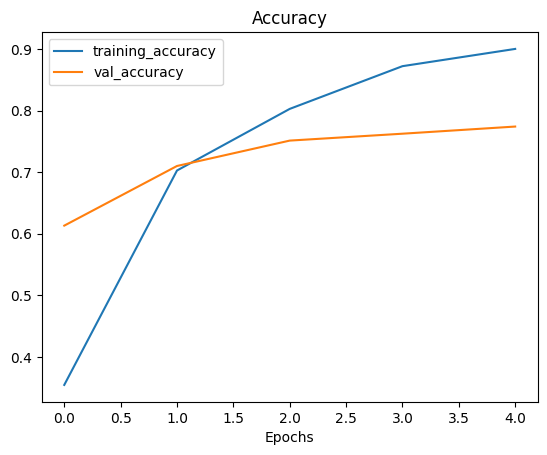

In [16]:

plot_loss_curves(resnet_history)